In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import dill
import itertools
random_state = 10 # Ensure reproducible results
%matplotlib inline

In [3]:
ing_mat = loadmat('MATLAB/ingredients.mat')['ingredients']
cityDist_mat = loadmat('MATLAB/citiesDistMat.mat')['citiesDistMat']
labelName_mat = loadmat('MATLAB/labelNames.mat')['labelNames']
labelName_mat = [item for sublist in labelName_mat for item in sublist]
labels_mat = loadmat('MATLAB/labels.mat')['labels']
recipe_mat = loadmat('MATLAB/recipes.mat')['recipes']
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])
dataset_X = pd.DataFrame(recipe_mat,columns=ing_headline)
dataset_y = pd.DataFrame(labelName_mat,columns=['label'])
X_train_full,X_test,y_train_full,y_test = train_test_split(dataset_X,dataset_y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.25)
cuisines = np.unique(labelName_mat)

In [6]:
def plot_confusion_matrix(cm, class_labels=None):
    """Plots a confusion matrix using seaborn's heatmap function
    
    Columns and rows are labelled with the strings provided in class_labels.
    
    Parameters
    ----------
    cm: array-like
        contains the confusion matrix
        
    class_labels: array-like, optional
        contains the string labels
            
    """
    
    # check whether we have count data or not
    if issubclass(cm.dtype.type, np.integer):
        fmt = 'd'
    else:
        fmt='.2%'
    
    # Your code goes here
    
    if class_labels is not None:
        sns.heatmap(cm, cmap='viridis',xticklabels=class_labels, yticklabels=class_labels,\
                    annot=True, annot_kws={"fontsize":9},  fmt=fmt)  # controls the display of the numbers
    else:
        sns.heatmap(cm, annot=True, annot_kws={"fontsize":9},  fmt=fmt)
        
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    
    # you can change the appearance of the figure with lower-level matplotlib commands
    # here we rotate the labels on the x-axis
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.show()

In [137]:
##########################################################################
# define mask_data:
# a function that takes input of dataset and ingredients intended to mask
# and return the masked dataset
def mask_data (dataset,ing):
    try:
        dataset_masked = dataset.drop(columns=[ing])
        return dataset_masked
    except:
        print("ing could not be found in the dataset")
#########################################################################
# define subgroup:
# a function that takes input of dataset along with the labels and subgroup the dataset depending on modes
def subgroup (dataset=None,labels=None, mode=None, target_cusine=None):
    if (mode != 'Continent' and mode != 'Country' and mode != 'Other'):
        print ("mode should be either 'Continent' or 'Country'")
        raise        
    if (mode == 'Continent'): # case when we want to group the countries into continents
        Asia = ['Chinese','Indian','Japanese','Thai']
        Europe = ['English','French','German','Italian','Greek','Spanish']
        NorthAmerica = ['Mexican']
        SouthAfrica = ['Moroccan']
        new_labels = labels.copy()
        for index, row in labels.iterrows():
            label = row['label']
            if label in Asia:
                new_labels.loc[index]='Asia'
            if label in Europe:
                new_labels.loc[index]='Europe'
            if label in NorthAmerica:
                new_labels.loc[index]='NorthAmerica'
            if label in SouthAfrica:
                new_labels.loc[index]='SouthAfrica'
        return new_labels
    # case when we want the subgroup of the countries
    if (mode == 'Country'):
        new_dataset = dataset.copy()
        new_labels = labels.copy()
        for idx, row in labels.iterrows():
            label = row['label']
            if label not in target_cusine:
                new_dataset.drop(index=[idx],inplace=True)
                new_labels.drop(index=[idx],inplace=True)
        return new_dataset,new_labels
    # case when we want to mark all the other recipe into others 
    new_labels = labels.copy()
    for idx, row in labels.iterrows():
        label = row['label']
        if label not in target_cusine:
            new_labels.loc[idx]='Other'
    return new_labels
#########################################################################
# define getKeys
# a function that find the the top keys that has max or min values given the dictionary
def getKeys(dictionary, mode, number):
    d = dictionary.copy()
    l = []
    if (mode != 'max' and mode != 'min'):
        print ('mode should be max or min')
        raise
    if (mode == 'max'):
        for _ in range(number):
            key = max(d, key=d.get)
            l.append(key)
            del d[key]
        return l
    for _ in range(number):
        key = min(d, key=d.get)
        l.append(key)
        del d[key]
    return l
######################################################################
# mask the dataset and train the mdoel using the masked data
# return prediction, accuracy scores and loss
def mask_training (X_train, y_train, X_val, y_val, mask_ing):
    model = LogisticRegression(max_iter=1000)
    X_train_masked = mask_data (X_train , mask_ing)
    X_val_masked = mask_data (X_val,  mask_ing)
    model.fit(X_train_masked,np.ravel(y_train))
    predict_logreg_val = model.predict(X_val_masked)
    score = model.score(X_val_masked, y_val)
    loss = log_loss(y_val, model.predict_proba(X_val_masked))    
    return predict_logreg_val,score,loss

######################################################################
# find the most important ingredient in the given dataset by iteratively masking the ingredients
# return the scores, losses and predictions after masking each ingredient
def findMostImportantIng (X_train, y_train, X_val, y_val):
    scores= {}
    losses = {}
    preds = {} 
    for ing in ing_headline:
        pred,score,loss = mask_training(X_train,y_train,X_val,y_val,mask_ing=ing)
        scores[ing]=score
        preds[ing]=pred
        losses[ing]=loss
    return scores,losses,preds
######################################################################
# visualise the result in confusion matrix
def visualise_topIng (groudTruth,preds,scores,losses,number=10):
    class_labels = np.unique(groudTruth)
    
    print ("original plot without masking with acc {}".format(scores['ORIGIN']))
    pred = preds['ORIGIN']
    cm_log_reg = confusion_matrix(groudTruth, pred, normalize='true')
    plot_confusion_matrix(cm_log_reg, class_labels=class_labels)     
    
    keys = getKeys(losses,'max',number)
    for key in keys:
        print ("ingredient {} with acc {}".format(key,scores[key]))
        pred = preds[key]
        cm_log_reg = confusion_matrix(groudTruth, pred, normalize='true')
        plot_confusion_matrix(cm_log_reg, class_labels=class_labels)
    return keys

######################################################################
# find the most important ingredient in continent or subgroup of countries
# return scores, losses and predictions after masking each ingredient
def subgroupAndFind (X_train=None,y_train=None,X_val=None,y_val=None,mode=None,target_cusine=None):
    if (mode != 'Continent' and mode != 'Country'):
        print ('mode should be Continent or Country')
        raise
    if (mode == 'Continent'):
        y_train_cont = subgroup(labels=y_train,mode=mode)
        y_val_cont = subgroup(labels=y_val,mode=mode)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, np.ravel(y_train_cont))
        predict_logreg_val_cont = model.predict(X_val)
        score_cont = model.score(X_val, y_val_cont)
        loss_cont = log_loss(y_val_cont, model.predict_proba(X_val))
        scores,losses,preds = findMostImportantIng (X_train,y_train_cont,X_val,y_val_cont)
        scores ['ORIGIN'] = score_cont
        losses ['ORIGIN'] = loss_cont
        preds ['ORIGIN'] = predict_logreg_val_cont
        return scores,losses,preds,y_train_cont,y_val_cont
    if (mode == 'Country'):
        X_train_new, y_train_new = subgroup(X_train,y_train,mode,target_cusine)
        X_val_new, y_val_new = subgroup(X_val,y_val,mode,target_cusine)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_new, np.ravel(y_train_new))
        predict_logreg_val = model.predict(X_val_new)
        score = model.score(X_val_new, y_val_new)
        loss = log_loss(y_val_new, model.predict_proba(X_val_new))
        scores,losses,preds = findMostImportantIng (X_train_new,y_train_new,X_val_new,y_val_new)
        scores ['ORIGIN'] = score
        losses ['ORIGIN'] = loss
        preds ['ORIGIN'] = predict_logreg_val
        return scores,losses,preds,y_train_new,y_val_new

In [135]:
def set_weights(distribution, N, scale=0.5, alpha=2, beta=8, shape=2, df=4): # default hyperparameters
    np.random.seed(42)
    if distribution == "exp":
        p = np.random.exponential(scale=scale, size=N) # generate a vector of unscaled probabilities from an exponential distribution
        p = np.sort(p)[::-1] # sorting the vector in reverse order
        p_scaled = p/sum(p) # scaling the vector down to probabilities
        return p_scaled # printing
    elif distribution == "beta":
        p = np.random.beta(a=alpha, b=beta, size=N) 
        p = np.sort(p)[::-1] 
        p_scaled = p/sum(p) 
        return p_scaled
    elif distribution == "gamma":
        p = np.random.gamma(shape=shape, size=N) 
        p = np.sort(p)[::-1] 
        p_scaled = p/sum(p) 
        return p_scaled
    elif distribution == "chi2":
        p = np.random.chisquare(df=df, size=N)
        p = np.sort(p)[::-1] 
        p_scaled = p/sum(p) 
        return p_scaled
    else:
        print("Distributions available with default hyperparameters: \n",
              "Exponential: exp(scale=0.5) \n", 
              "Beta: beta(alpha=2, beta=8) \n", 
              "Gamma: gamma(shape=2) \n", 
              "Chi-squared: chi2(df=4)")
def toward_more (ing, cuisine1, cuisine2, freq):
    if ing in freq[cuisine1].keys() and ing in freq[cuisine2].keys():
        if freq[cuisine1][ing]>=freq[cuisine2][ing]:
            return cuisine1
        else:
            return cuisine2
    if ing in freq[cuisine1].keys():
        return cuisine1
    if ing in freq[cuisine2].keys():
        return cuisine2
    print ('something wrong because ing not in both cuisine {} and {}'.format(cuisine1,cuisine2))
    raise
def getKeys_new(dictionary, mode, cuisine1,cuisine2, freq, number):
    d = dictionary.copy()
    l = []
    n = 0
    if (mode != 'max' and mode != 'min'):
        print ('mode should be max or min')
        raise
    if (mode == 'max'):
        while n < number:
            key = max(d, key=d.get)
            if toward_more(key,cuisine1,cuisine2,freq) == cuisine1:
                l.append(key)
                n+=1
            del d[key]
        return l
    while n < number:
        key = min(d, key=d.get)
        if toward_more(key,cuisine1,cuisine2,freq) == cuisine1:
            l.append(key)
            n+=1
        del d[key]
    return l

def weighted_Count (top_ings,weights):
    dic = {}
    for row in top_ings:
        index = 0 
        for ing in row:
            if ing in dic.keys():
                dic[ing] += weights[index]
            else:
                dic[ing] = weights[index]
            index += 1
    tops = getKeys(dic, 'max', len(weights))
    return tops
def getMostImportant (dictionary,mode,cuisine,freq,number,weights):
    tops = []
    for cuisine1,cuisine2 in dictionary.keys():
        if cuisine == cuisine1:
            topRep = getKeys_new(dictionary[(cuisine1,cuisine2)],mode,cuisine1,cuisine2,freq,number)
            tops.append(topRep)
        if cuisine == cuisine2:
            topRep = getKeys_new(dictionary[(cuisine1,cuisine2)],mode,cuisine2,cuisine1,freq,number)
            tops.append(topRep)
    return weighted_Count(tops,weights)
def count_frequency (X_train,y_train,cuisines,ing_headline):
    freq = {}
    for c in cuisines:
        freq[c] = {}
    for idx, row in y_train.iterrows():
        label = row['label']
        ings = np.where(X_train.loc[idx]==1)[0]
        ings_name = [ing_headline[i] for i in ings]
        for name in ings_name:
            try:
                freq[label][name] += 1
            except:
                freq[label][name] = 1
    return freq

# Find the most important ingradient that distinguish between different continents

### Baseline before group into continents:

/Users/Ming/miniconda2/envs/monitor/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Performance on the val set
Classification accuracy: 0.7721369539551358
Log-loss: 0.7498630398164529


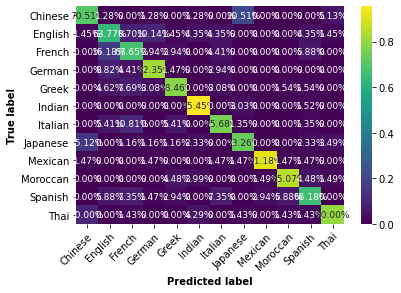

In [194]:
#baseline
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
predict_logreg_val = model.predict(X_val)
score = model.score(X_val, y_val)
loss = log_loss(y_val, model.predict_proba(X_val))
print("Performance on the val set")
print("Classification accuracy:", score)
print("Log-loss:", loss)
cm_log_reg = confusion_matrix(y_val, predict_logreg_val, normalize='true')
plot_confusion_matrix(cm_log_reg, class_labels=cuisines)

### After group into continents:

Performance on the val set
Classification accuracy: 0.9338842975206612
Log-loss: 0.2020727912827666


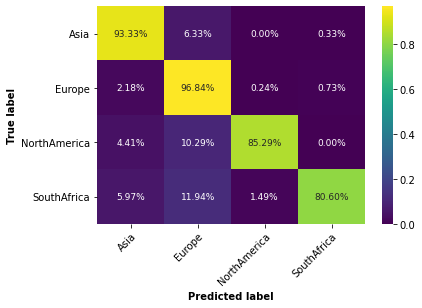

In [195]:
y_train_cont = subgroup(labels=y_train,mode='Continent')
y_val_cont = subgroup(labels=y_val,mode='Continent')
continents = np.unique(y_val_cont)
model_cont = LogisticRegression(max_iter=1000)
model_cont.fit(X_train, np.ravel(y_train_cont))
predict_logreg_val_cont = model_cont.predict(X_val)
score_cont = model_cont.score(X_val, y_val_cont)
loss_cont = log_loss(y_val_cont, model_cont.predict_proba(X_val))
print("Performance on the val set")
print("Classification accuracy:", score_cont)
print("Log-loss:", loss_cont)
cm_log_reg_cont = confusion_matrix(y_val_cont, predict_logreg_val_cont, normalize='true')
plot_confusion_matrix(cm_log_reg_cont, class_labels=continents)

### Iteratively mask through ingredients:

In [334]:
scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train,X_val,y_val,mode='Continent')


original plot without masking with acc 0.9256198347107438


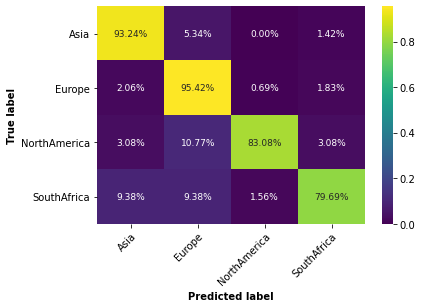

ingredient curry powder with acc 0.9161747343565525


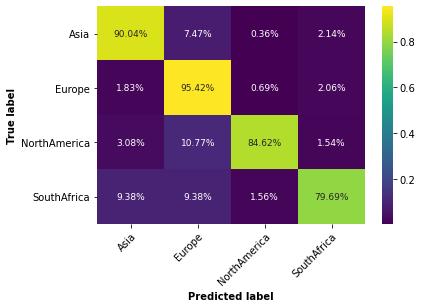

ingredient tortilla with acc 0.9232585596221959


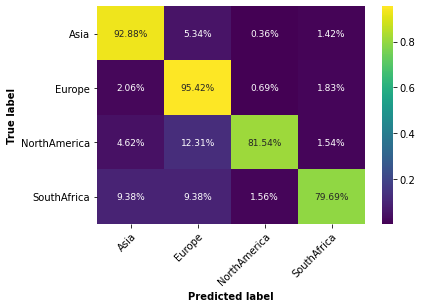

ingredient olive oil with acc 0.9244391971664699


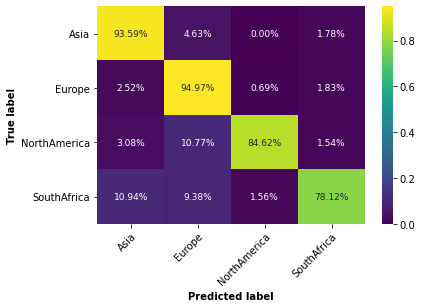

ingredient soy sauce with acc 0.9256198347107438


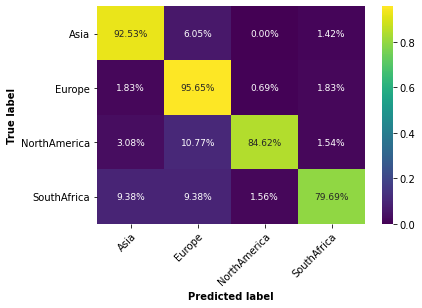

ingredient ginger with acc 0.9232585596221959


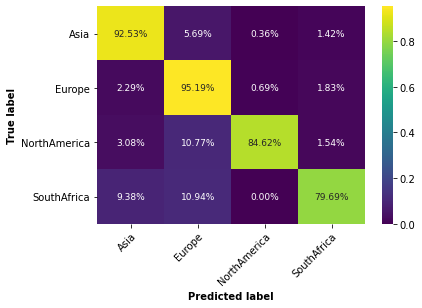

ingredient cumin with acc 0.9268004722550177


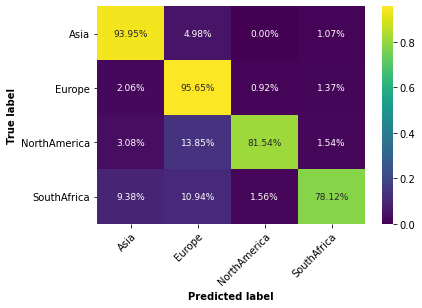

ingredient coconut milk or cream with acc 0.9232585596221959


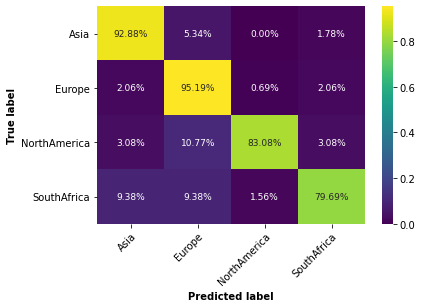

ingredient ras el hanout with acc 0.9232585596221959


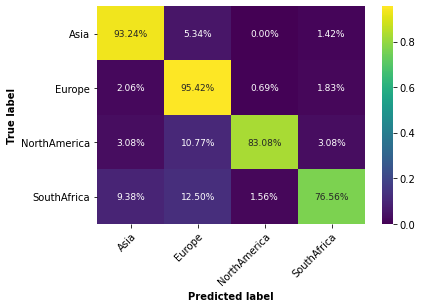

ingredient harissa with acc 0.922077922077922


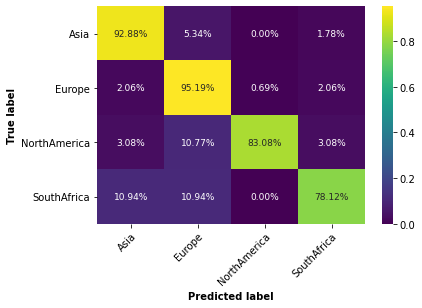

ingredient oregano with acc 0.9268004722550177


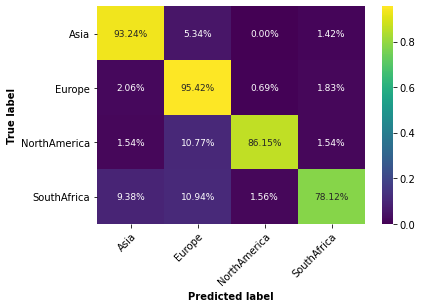

In [335]:
topIng = visualise_topIng(y_val_new,preds,scores,losses)

# Find the most important ingredient between different Continents

In [94]:
import pickle
continents = ['Asia','Europe','NorthAmerica','SouthAfrica']
all_comb = list(itertools.combinations(continents, 2))
scores_all_2 = {}
losses_all_2 = {}
preds_all_2 = {}
y_val_new_all_2 = {}
top_ing_all_2 = {}
y_train_cont = subgroup(labels=y_train,mode='Continent')
y_val_cont = subgroup(labels=y_val,mode='Continent')
for cusine1,cusine2 in all_comb:
    scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train_cont,X_val,y_val_cont,mode='Country',target_cusine =[cusine1,cusine2])
    keys = getKeys(losses,'max',10)
    scores_all_2 [cusine1,cusine2] = scores
    losses_all_2 [cusine1,cusine2] = losses
    preds_all_2 [cusine1,cusine2] = preds
    y_val_new_all_2 [cusine1,cusine2] = y_val_new
    top_ing_all_2 [cusine1,cusine2] = keys
    print ("top 10 ingredients between cuisines {} and {} are : ".format(cusine1,cusine2))
    print (keys)

# Store the session
dataset_2 = [scores_all_2,losses_all_2,preds_all_2,y_val_new_all_2,top_ing_all_2] 
outputFile = 'test_2.data'
fw = open(outputFile, 'wb')
pickle.dump(dataset, fw)
fw.close()

top 10 ingredients between cuisines Asia and Europe are : 
['ginger', 'soy sauce', 'olive oil', 'sugar', 'wine', 'parsley', 'potato', 'vegetable oil', 'flour', 'tofu']
top 10 ingredients between cuisines Asia and NorthAmerica are : 
['tortilla', 'ginger', 'chipotle pepper', 'soy sauce', 'jack cheese', 'salsa', 'curry powder', 'beef', 'turmeric', 'vegetable oil']
top 10 ingredients between cuisines Asia and SouthAfrica are : 
['parsley', 'olive oil', 'lamb', 'raisin', 'almond', 'honey', 'vegetable oil', 'ginger', 'chickpea', 'couscous']
top 10 ingredients between cuisines Europe and NorthAmerica are : 
['tortilla', 'chili powder', 'taco seasoning', 'olive oil', 'enchilada sauce', 'chipotle pepper', 'jack cheese', 'sour cream', 'wine', 'orange juice']
top 10 ingredients between cuisines Europe and SouthAfrica are : 
['cumin', 'ginger', 'turmeric', 'harissa', 'ras el hanout', 'cilantro', 'coriander', 'wine', 'oregano', 'feta cheese']
top 10 ingredients between cuisines NorthAmerica and So

In [107]:
number=10
weights = set_weights(distribution="exp", N=number)
freq = count_frequency(X_train,y_train_cont,continents,ing_headline)
tops = {}
for c in continents:
    tops [c] = getMostImportant(losses_all_2,'max',c,freq,number,weights)
print (weights)
print (tops)

[0.29310702 0.19584123 0.12821656 0.11989152 0.08949454 0.0888967
 0.04569443 0.01651702 0.01651424 0.00582673]
{'Asia': ['ginger', 'soy sauce', 'vegetable oil', 'curry powder', 'honey', 'sugar', 'beef', 'yogurt', 'tofu', 'turmeric'], 'Europe': ['wine', 'olive oil', 'potato', 'sour cream', 'oregano', 'feta cheese', 'sausage', 'parsley', 'orange juice', 'flour'], 'NorthAmerica': ['tortilla', 'chili powder', 'chipotle pepper', 'jack cheese', 'enchilada sauce', 'lime', 'taco seasoning', 'pork', 'salsa', 'oregano'], 'SouthAfrica': ['cumin', 'cinnamon', 'parsley', 'olive oil', 'chickpea', 'turmeric', 'lamb', 'ginger', 'harissa', 'raisin']}


# Find the most representative ingredient for a continent by group the rest continents to others

In [170]:
import pickle
length = len(cuisines)
OTHERS = ['Other']*length
continents = ['Asia','Europe','NorthAmerica','SouthAfrica']
all_comb = list(zip(continents,OTHERS))
scores_all_4 = {}
losses_all_4 = {}
preds_all_4 = {}
y_train_new_all_4 = {}
y_val_new_all_4 = {}
top_ing_all_4 = {}
y_train_cont_b = subgroup(labels=y_train,mode='Continent')
y_val_cont_b = subgroup(labels=y_val,mode='Continent')
for cusine1,cusine2 in all_comb:
    y_train_cont = subgroup(labels=y_train_cont_b,mode='Other',target_cusine=[cusine1])
    y_val_cont = subgroup(labels=y_val_cont_b,mode='Other',target_cusine=[cusine1])
    scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train_cont,X_val,y_val_cont,mode='Country',target_cusine =[cusine1,cusine2])
    keys = getKeys(losses,'max',10)
    scores_all_4 [cusine1,cusine2] = scores
    losses_all_4 [cusine1,cusine2] = losses
    preds_all_4 [cusine1,cusine2] = preds
    y_val_new_all_4 [cusine1,cusine2] = y_val_new
    y_train_new_all_4 [cusine1,cusine2]= y_train_cont
    top_ing_all_4 [cusine1,cusine2] = keys
    print ("top 10 ingredients between cuisines {} and {} are : ".format(cusine1,cusine2))
    print (keys)

# Store the session
dataset_4 = [scores_all_4,losses_all_4,preds_all_4,y_train_new_all_4,y_val_new_all_4,top_ing_all_4] 
outputFile = 'test_4.data'
fw = open(outputFile, 'wb')
pickle.dump(dataset, fw)
fw.close()



top 10 ingredients between cuisines Asia and Other are : 
['ginger', 'parsley', 'curry powder', 'soy sauce', 'olive oil', 'vegetable oil', 'tortilla', 'sugar', 'fish sauce', 'beef']
top 10 ingredients between cuisines Europe and Other are : 
['ginger', 'tortilla', 'wine', 'soy sauce', 'feta cheese', 'potato', 'cinnamon', 'cumin', 'olive oil', 'taco seasoning']
top 10 ingredients between cuisines NorthAmerica and Other are : 
['tortilla', 'chili powder', 'chipotle pepper', 'enchilada sauce', 'taco seasoning', 'jack cheese', 'olive oil', 'ginger', 'orange juice', 'ancho chile pepper']
top 10 ingredients between cuisines SouthAfrica and Other are : 
['cumin', 'parsley', 'harissa', 'ras el hanout', 'honey', 'lamb', 'cinnamon', 'cilantro', 'sausage', 'pea']


In [172]:
number=10
tops = {}
for continent in continents:
    y_train_cont = y_train_new_all_4 [(continent,'Other')]
    cc = [continent,'Other']
    freq = count_frequency(X_train,y_train_cont,cc,ing_headline)
    tops [continent] = getKeys_new(losses_all_4[(continent,'Other')],'max',continent,'Other',freq,number)
print (tops)

{'Asia': ['ginger', 'curry powder', 'soy sauce', 'vegetable oil', 'sugar', 'fish sauce', 'broccoli', 'yogurt', 'turmeric', 'tofu'], 'Europe': ['wine', 'feta cheese', 'potato', 'olive oil', 'sausage', 'parmesan cheese', 'oregano', 'nutmeg', 'flour', 'balsamic vinegar'], 'NorthAmerica': ['tortilla', 'chipotle pepper', 'enchilada sauce', 'taco seasoning', 'jack cheese', 'ancho chile pepper', 'jalapeno pepper', 'Mexican blend cheese', 'refried beans', 'velveeta'], 'SouthAfrica': ['harissa', 'ras el hanout', 'couscous', 'butternut squash', 'sultana', 'dried apricot', 'brown onion', 'preserved lemon', 'smen', 'prune']}


# Find the most important ingredient between Chinese and Indian

In [6]:
scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train,X_val,y_val,mode='Country',target_cusine =['Chinese','Indian'])


original plot without masking with acc 0.9952941176470588


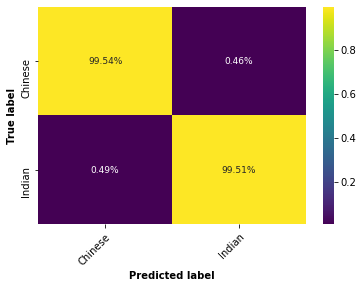

ingredient soy sauce with acc 0.9976470588235294


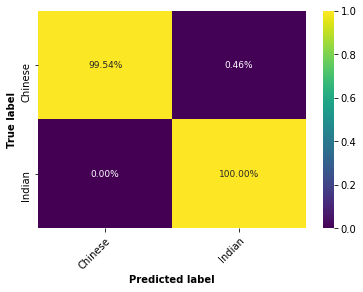

ingredient masala with acc 0.9929411764705882


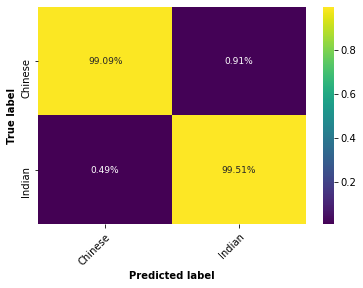

ingredient yogurt with acc 0.9952941176470588


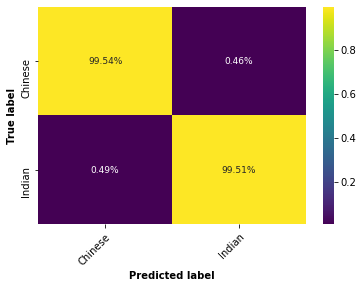

ingredient chicken stock with acc 0.9952941176470588


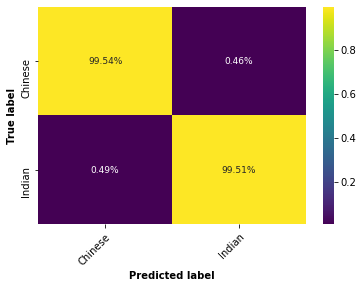

ingredient curry powder with acc 0.9952941176470588


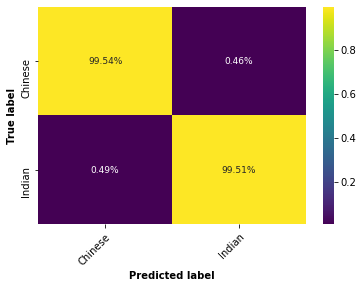

ingredient onion with acc 0.9952941176470588


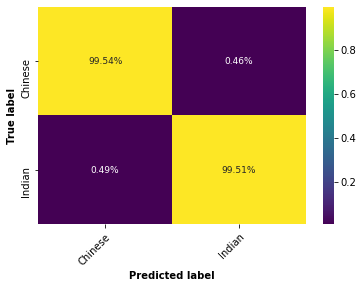

ingredient cornstarch with acc 0.9929411764705882


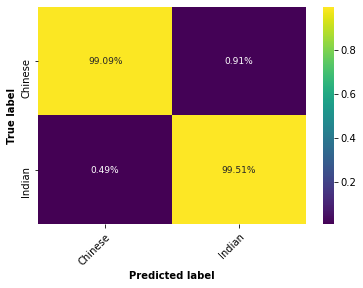

ingredient tomato puree with acc 0.9952941176470588


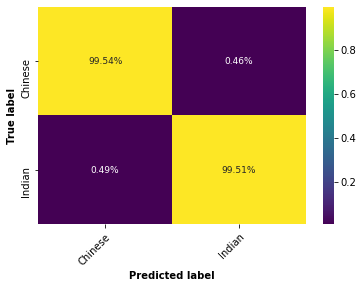

ingredient sesame oil with acc 0.9952941176470588


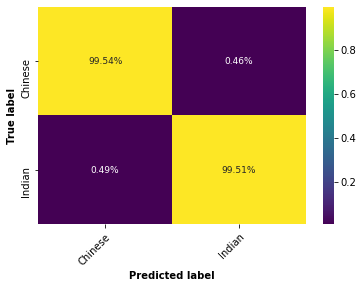

ingredient coconut milk or cream with acc 0.9952941176470588


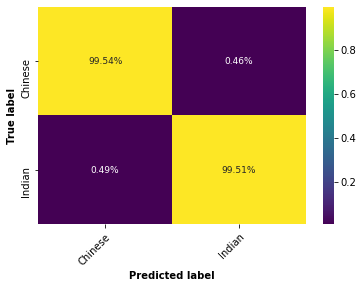

['soy sauce', 'masala', 'yogurt', 'chicken stock', 'curry powder', 'onion', 'cornstarch', 'tomato puree', 'sesame oil', 'coconut milk or cream']
ingredient is soy sauce
frequency the ingredient soy sauce been in chinese cuisine is 58
frequency the ingredient soy sauce been in japanese cuisine is 3


ingredient is masala
frequency the ingredient masala been in chinese cuisine is 0
frequency the ingredient masala been in japanese cuisine is 18


ingredient is yogurt
frequency the ingredient yogurt been in chinese cuisine is 0
frequency the ingredient yogurt been in japanese cuisine is 9


ingredient is chicken stock
frequency the ingredient chicken stock been in chinese cuisine is 1
frequency the ingredient chicken stock been in japanese cuisine is 5


ingredient is curry powder
frequency the ingredient curry powder been in chinese cuisine is 1
frequency the ingredient curry powder been in japanese cuisine is 22


ingredient is onion
frequency the ingredient onion been in chinese cuisine

In [339]:
topIng = visualise_topIng(y_val_new,preds,scores,losses)
print (topIng)
for ing in topIng:
    print ("ingredient is {}".format(ing))
    idx = np.array(np.where(X_val[ing]==1)).squeeze()
    chinese_c = 0
    japanese_c = 0
    for i in idx:
        if (y_val.iloc[i].label == 'Chinese'):
            chinese_c +=1
        if (y_val.iloc[i].label == 'Indian'):
            japanese_c +=1
    print ('frequency the ingredient {} been in chinese cuisine is {}'.format(ing,chinese_c))
    print ('frequency the ingredient {} been in indian cuisine is {}'.format(ing,japanese_c))
    print ("\n")

# Iterate through all combinations between countries

In [228]:
import pickle

all_comb = list(itertools.combinations(cuisines, 2))
scores_all = {}
losses_all = {}
preds_all = {}
y_val_new_all = {}
top_ing_all = {}
for cusine1,cusine2 in all_comb:
    scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train,X_val,y_val,mode='Country',target_cusine =[cusine1,cusine2])
    keys = getKeys(losses,'max',10)
    scores_all [cusine1,cusine2] = scores
    losses_all [cusine1,cusine2] = losses
    preds_all [cusine1,cusine2] = preds
    y_val_new_all [cusine1,cusine2] = y_val_new
    top_ing_all [cusine1,cusine2] = keys
    print ("top 10 ingredients between cuisines {} and {} are : ".format(cusine1,cusine2))
    print (keys)

# Store the session
dataset = [scores_all,losses_all,preds_all,y_val_new_all,top_ing_all] 
outputFile = 'test.data'
fw = open(outputFile, 'wb')
pickle.dump(dataset, fw)
fw.close()

top 10 ingredients between cuisines Chinese and English are : 
['ginger', 'sweet pepper', 'sugar', 'brown sugar', 'rice', 'chicken', 'potato', 'vinegar', 'vegetable oil', 'sesame seed']
top 10 ingredients between cuisines Chinese and French are : 
['ginger', 'wine', 'sweet pepper', 'soy sauce', 'brown sugar', 'olive oil', 'thyme', 'butter', 'parsley', 'sugar']
top 10 ingredients between cuisines Chinese and German are : 
['ginger', 'sweet pepper', 'chicken', 'pepper', 'soy sauce', 'sesame seed', 'vegetable oil', 'cornstarch', 'salt', 'sauerkraut']
top 10 ingredients between cuisines Chinese and Greek are : 
['olive oil', 'oregano', 'ginger', 'sweet pepper', 'lemon juice', 'soy sauce', 'brown sugar', 'feta cheese', 'sugar', 'parsley']
top 10 ingredients between cuisines Chinese and Indian are : 
['curry powder', 'turmeric', 'cornstarch', 'garlic', 'sugar', 'cumin', 'masala', 'coriander', 'oyster sauce', 'coconut milk or cream']
top 10 ingredients between cuisines Chinese and Italian are

top 10 ingredients between cuisines Greek and Thai are : 
['olive oil', 'oregano', 'lemon juice', 'soy sauce', 'coconut milk or cream', 'ginger', 'parsley', 'cilantro', 'sugar', 'feta cheese']
top 10 ingredients between cuisines Indian and Italian are : 
['curry powder', 'ginger', 'pasta', 'onion', 'basil', 'masala', 'cilantro', 'chickpea', 'turmeric', 'mozzarella']
top 10 ingredients between cuisines Indian and Japanese are : 
['curry powder', 'soy sauce', 'turmeric', 'cumin', 'flour', 'carrot', 'cilantro', 'broth', 'lentil', 'curry paste']
top 10 ingredients between cuisines Indian and Mexican are : 
['curry powder', 'tortilla', 'masala', 'turmeric', 'oregano', 'jalapeno pepper', 'sweet pepper', 'vegetable oil', 'yogurt', 'chickpea']
top 10 ingredients between cuisines Indian and Moroccan are : 
['curry powder', 'parsley', 'masala', 'olive oil', 'honey', 'cinnamon', 'couscous', 'ginger', 'saffron', 'ghee']
top 10 ingredients between cuisines Indian and Spanish are : 
['curry powder',

# Most the confusion ingredients (not working)

In [284]:
conf_ing_all = {}
for comb in losses_all.keys():
    
    losses = losses_all[comb] 
    score = scores_all [comb]
    keys = getKeys(score,'min',10)
    conf_ing_all[comb] = keys
    print ("the baseline acc between cuisine {} is: {}".format(comb, score['ORIGIN']))
    print ("the most confusion ingredients between cuisine {} are in acc:".format(comb))
    print (keys)
    l = [score[key] for key in keys]
    print ("with score: {}".format(l))

the baseline acc between cuisine ('Chinese', 'English') is: 0.9523809523809523
the most confusion ingredients between cuisine ('Chinese', 'English') are in acc:
['chicken', 'salt', 'butter', 'canola oil', 'cornstarch', 'five spice powder', 'garlic', 'ginger', 'green onion', 'hoisin sauce']
with score: [0.9387755102040817, 0.9387755102040817, 0.9455782312925171, 0.9455782312925171, 0.9455782312925171, 0.9455782312925171, 0.9455782312925171, 0.9455782312925171, 0.9455782312925171, 0.9455782312925171]
the baseline acc between cuisine ('Chinese', 'French') is: 0.9794520547945206
the most confusion ingredients between cuisine ('Chinese', 'French') are in acc:
['butter', 'bacon', 'bamboo shoot', 'broth', 'brown sugar', 'ginger', 'ham', 'olive oil', 'parsley', 'pepper']
with score: [0.958904109589041, 0.9726027397260274, 0.9726027397260274, 0.9726027397260274, 0.9726027397260274, 0.9726027397260274, 0.9726027397260274, 0.9726027397260274, 0.9726027397260274, 0.9726027397260274]
the baseline a

In [283]:
conf_ing_all = {}
for comb in losses_all.keys():
    
    losses = losses_all[comb] 
    score = scores_all [comb]
    keys = getKeys(losses,'max',3)
    conf_ing_all[comb] = keys
    print ("the baseline acc between cuisine {} is: {}".format(comb, losses['ORIGIN']))
    print ("the most confusion ingredients between cuisine {} are in losses:".format(comb))
    print (keys)
    l = [losses[key] for key in keys]
    print ("with losses: {}".format(l))

the baseline acc between cuisine ('Chinese', 'English') is: 0.11801167653077069
the most confusion ingredients between cuisine ('Chinese', 'English') are in losses:
['ginger', 'sweet pepper', 'sugar']
with losses: [0.1394402985924511, 0.130553262138432, 0.12670051159861054]
the baseline acc between cuisine ('Chinese', 'French') is: 0.07475011465561995
the most confusion ingredients between cuisine ('Chinese', 'French') are in losses:
['ginger', 'wine', 'sweet pepper']
with losses: [0.08839203052137656, 0.0844665364860108, 0.08304909957506948]
the baseline acc between cuisine ('Chinese', 'German') is: 0.11091274447199848
the most confusion ingredients between cuisine ('Chinese', 'German') are in losses:
['ginger', 'sweet pepper', 'chicken']
with losses: [0.12362795902551874, 0.12019908812436642, 0.11810622050688234]
the baseline acc between cuisine ('Chinese', 'Greek') is: 0.04558455531015312
the most confusion ingredients between cuisine ('Chinese', 'Greek') are in losses:
['olive oil'

# Find the most important representative ingredient for each country 

In [82]:
number=10
weights = set_weights(distribution="exp", N=number)
freq = count_frequency(X_train,y_train,cuisines,ing_headline)
tops = {}
for cuisine in cuisines:
    print (cuisine)
    tops [cuisine] = getMostImportant(losses_all,'max',cuisine,freq,number,weights)
print (weights)
print (tops)

Chinese
English
French
German
Greek
Indian
Italian
Japanese
Mexican
Moroccan
Spanish
Thai
[0.29310702 0.19584123 0.12821656 0.11989152 0.08949454 0.0888967
 0.04569443 0.01651702 0.01651424 0.00582673]
{'Chinese': ['ginger', 'cornstarch', 'sweet pepper', 'brown sugar', 'soy sauce', 'vegetable oil', 'sugar', 'chicken', 'sesame seed', 'pineapple'], 'English': ['cheddar cheese', 'sausage', 'thyme', 'sage', 'flour', 'potato', 'mustard prepared', 'rosemary', 'wine vinegar', 'egg'], 'French': ['wine', 'mustard prepared', 'thyme', 'butter', 'olive oil', 'parsley', 'rosemary', 'shallot', 'breadcrumb', 'salt'], 'German': ['beer', 'potato', 'sauerkraut', 'bacon', 'pepper', 'sour cream', 'caraway seed', 'bratwursts', 'beef', 'mustard prepared'], 'Greek': ['feta cheese', 'lemon juice', 'oregano', 'olive oil', 'cinnamon', 'parsley', 'lemon', 'tomato paste', 'wine', 'lamb'], 'Indian': ['curry powder', 'turmeric', 'masala', 'ginger', 'cilantro', 'yogurt', 'chickpea', 'cumin', 'chili powder', 'salt'],

# Naive Approach

In [8]:
def naiveApproch (cuisine, cuisines, freq):
    freq1 = freq[cuisine]
    rest_cui = list(cuisines.copy())
    rest_cui.remove(cuisine)
    unique_key = list (freq1.keys())
    rest_keys = [freq[c].keys() for c in rest_cui]
    for key in freq1.keys():
        for rest_key in rest_keys:
            if key in rest_key:
                if key in unique_key:
                    unique_key.remove(key)
    return unique_key

In [93]:
naive_top = {}
number = 10
for cuisine in cuisines:
    unique_keys = naiveApproch (cuisine,cuisines,freq)
    unique_key_freq = [freq[cuisine][k] for k in unique_keys]
    unique_keys = [x for _, x in sorted(zip(unique_key_freq, unique_keys),reverse=True)][:number]
    unique_key_freq = sorted(unique_key_freq,reverse=True)[:number]
    naive_top[cuisine] = (unique_keys,unique_key_freq)
    print ("unique ingredients for cuisine {} are {}".format(cuisine,unique_keys))
    print ("with the frequency {}".format(unique_key_freq))


unique ingredients for cuisine Chinese are ['hot bean paste', 'hokkien noodles', 'black mushroom', 'yellow food coloring', 'teriyaki marinade', 'screwpine leaves', 'golden syrup', 'egg roll wraps', 'French beans']
with the frequency [2, 2, 2, 1, 1, 1, 1, 1, 1]
unique ingredients for cuisine English are ['stilton', 'ale', 'marmite', 'mandarin orange', 'horseradish sauce', 'dripping', 'chestnut', 'baked beans', 'Guinness stout', 'Campbell']
with the frequency [5, 4, 3, 2, 2, 2, 2, 2, 2, 2]
unique ingredients for cuisine French are ['lardon', 'filet mignon', 'whole grain mustard', 'truffle', 'pastry dough', 'parchment paper', 'goose', 'endive', 'demi glace', 'cranberry bean']
with the frequency [3, 2, 1, 1, 1, 1, 1, 1, 1, 1]
unique ingredients for cuisine German are ['sauerkraut', 'bratwursts', 'pickle', 'gingersnaps', 'pickling spices', 'hoagie rolls', 'emmenthaler cheese', 'spaetzle', 'gingersnap cookie', 'black forest ham']
with the frequency [36, 19, 12, 7, 4, 3, 3, 2, 2, 2]
unique in

# Find the most representative ingredient for a country by group the rest cusines to others

In [158]:
import pickle
length = len(cuisines)
OTHERS = ['Other']*length
all_comb = list(zip(cuisines,OTHERS))
scores_all_3 = {}
losses_all_3 = {}
preds_all_3 = {}
y_train_new_all_3 = {}
y_val_new_all_3 = {}
top_ing_all_3 = {}
for cusine1,cusine2 in all_comb:
    y_train_cont = subgroup(labels=y_train,mode='Other',target_cusine=[cusine1])
    y_val_cont = subgroup(labels=y_val,mode='Other',target_cusine=[cusine1])
    scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train_cont,X_val,y_val_cont,mode='Country',target_cusine =[cusine1,cusine2])
    keys = getKeys(losses,'max',10)
    scores_all_3 [cusine1,cusine2] = scores
    losses_all_3 [cusine1,cusine2] = losses
    preds_all_3 [cusine1,cusine2] = preds
    y_val_new_all_3 [cusine1,cusine2] = y_val_cont
    y_train_new_all_3 [cusine1,cusine2] = y_train_cont
    top_ing_all_3 [cusine1,cusine2] = keys
    print ("top 10 ingredients between cuisines {} and {} are : ".format(cusine1,cusine2))
    print (keys)

# Store the session
dataset_3 = [scores_all_3,losses_all_3,preds_all_3,y_train_new_all_3,y_val_new_all_3,top_ing_all_3] 
outputFile = 'test_3.data'
fw = open(outputFile, 'wb')
pickle.dump(dataset, fw)
fw.close()

top 10 ingredients between cuisines Chinese and Other are : 
['soy sauce', 'cornstarch', 'fish sauce', 'parsley', 'dried chile pepper', 'sherry', 'five spice powder', 'radish', 'sesame oil', 'oyster sauce']
top 10 ingredients between cuisines English and Other are : 
['potato', 'cheddar cheese', 'sage', 'sweet pepper', 'puff pastry', 'barley', 'milk', 'wine', 'sour cream', 'sauerkraut']
top 10 ingredients between cuisines French and Other are : 
['thyme', 'gruyere', 'feta cheese', 'oregano', 'sausage', 'wine', 'paprika', 'potato', 'shallot', 'herbes de provence']
top 10 ingredients between cuisines German and Other are : 
['sauerkraut', 'caraway seed', 'cheddar cheese', 'garlic', 'bacon', 'cabbage', 'soy sauce', 'worcestershire sauce', 'nutmeg', 'olive oil']
top 10 ingredients between cuisines Greek and Other are : 
['feta cheese', 'oregano', 'lemon juice', 'Greek salad dressing', 'mint', 'sausage', 'lamb', 'saffron', 'tomato paste', 'lemon']
top 10 ingredients between cuisines Indian 

In [163]:
number=10
tops = {}
for cuisine in cuisines:
    y_train_cont = y_train_new_all_3 [(cuisine,'Other')]
    cc = [cuisine,'Other']
    freq = count_frequency(X_train,y_train_cont,cc,ing_headline)
    tops [cuisine] = getKeys_new(losses_all_3[(cuisine,'Other')],'max',cuisine,'Other',freq,number)
print (tops)

{'Chinese': ['cornstarch', 'five spice powder', 'sesame oil', 'oyster sauce', 'water chestnut', 'hoisin sauce', 'pineapple', 'maple syrup', 'zest', 'hot bean paste'], 'English': ['puff pastry', 'baking soda', 'baked beans', 'ale', 'Guinness stout', 'grape', 'stilton', 'mace', 'french style green bean', 'brown gravy mix'], 'French': ['gruyere', 'herbes de provence', 'brandy', 'cremini mushroom', 'duck', 'bouquet garni', 'pie crust', 'brie cheese', 'anchovy', 'goat cheese'], 'German': ['sauerkraut', 'caraway seed', 'beer', 'gingersnaps', 'roll', 'bratwursts', 'meat stock', 'beef round cuts', 'pickle', 'juniper berries'], 'Greek': ['feta cheese', 'Greek salad dressing', 'kalamata olive', 'pita bread', 'mizithra cheese', 'bulgur wheat', 'dill', 'gravy', 'savory', 'sardine'], 'Indian': ['curry powder', 'masala', 'yogurt', 'turmeric', 'cardamom', 'basmati rice', 'fenugreek', 'mustard seed and powder', 'red chile powder', 'coconut'], 'Italian': ['pasta', 'parmesan cheese', 'marsala', 'prosciu

### examples of how to set up weights

In [10]:
set_weights(distribution="exp", N=10)
set_weights(distribution="exp", scale=2, N=10)
set_weights(distribution="gamma", N=2)
set_weights(distribution="beta", alpha=0.5, beta=13, N=10)

array([0.52688186, 0.2969563 , 0.07177385, 0.04257669, 0.0210297 ,
       0.02010285, 0.00802106, 0.00499174, 0.0048545 , 0.00281145])

### Load the session

In [ ]:
import pickle
inputFile = 'test.data'
fd = open(inputFile, 'rb')
dataset = pickle.load(fd)
[scores_all,losses_all,preds_all,y_val_new_all,top_ing_all]  = dataset